In [46]:
"""
backtest_strategies.py

Contenu :
- strategy_1(df, x=0.02, tol=0.005)
- strategy_2(df, x=0.02, tol=0.005, growth_window=1)
- backtest(df, positions, initial_cash=10000, fee=0.0)

Usage:
- df must be a pandas.DataFrame with columns: 'date' (datetime), 'close' (float), 'prediction' (float).
  'prediction' contains the model's predicted price for the asset TWO days ahead.

Notes:
- Functions return positions series with values: 1 (long), -1 (short), 0 (flat).
- backtest returns a dictionary of metrics and plots an equity curve and drawdowns when run.

Example:
  from backtest_strategies import strategy_1, strategy_2, backtest
  metrics, results_df = backtest(df, strategy_1(df))

"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict

# -----------------------------
# Strategy 1: prediction vs current price
# -----------------------------

def strategy_1(df: pd.DataFrame, x: float = 0.01, tol: float = 0.005) -> pd.Series:
    """
    Entrées
    - df: DataFrame index aligned by time, with columns 'close' and 'prediction'.
      'prediction' forecasts price 2 days ahead.
    - x: seuil (fraction) au-delà duquel on considère une baisse significative -> on shorte / couvre.
    - tol: tolérance relative (fraction) pour continuer à garder la position même si la prédiction
           devient légèrement inférieure au cours actuel.

    Logique (approche pas-à-pas):
    - Si prediction > close -> open long (1)
    - Tant que prediction reste >= close * (1 - tol) ou continue d'être > close => garder position
    - Si prediction <= close * (1 - x) => prendre position short (-1)
    - Sinon mettre flat (0)

    Renvoie
    - pd.Series d'entiers {-1,0,1} alignée avec df.index
    """
    close = df['close'].astype(float)
    pred = df['prediction'].astype(float)
    n = len(df)

    pos = np.zeros(n, dtype=int)

    current_pos = 0
    for i in range(n):
        c = close.iloc[i]
        p = pred.iloc[i]

        if np.isnan(c) or np.isnan(p):
            pos[i] = 0
            current_pos = 0
            continue

        # Signal pour short (couverture) si prédiction très plus basse
        if p <= c * (1 - x):
            current_pos = -1
        else:
            # Si la prédiction est supérieure au cours actuel -> long
            if p > c:
                # open long
                current_pos = 1
            else:
                # prédiction <= cours
                # si on est déjà long, on conserve tant que la prédiction n'a pas chuté de plus que tol
                if current_pos == 1:
                    if p < c * (1 - tol):
                        # perdre confiance -> fermer
                        current_pos = 0
                    else:
                        # on garde
                        current_pos = 1
                else:
                    # si on est flat ou short, et pas de signal fort, rester flat
                    if current_pos == -1:
                        # si short et la prédiction redevient proche du cours, fermer
                        if p >= c * (1 - tol):
                            current_pos = 0
                        else:
                            current_pos = -1
                    else:
                        current_pos = 0

        pos[i] = current_pos

    return pd.Series(pos, index=df.index, name='position')


# -----------------------------
# Strategy 2: based on growth rate of predictions
# -----------------------------

def strategy_2(df: pd.DataFrame, x: float = 0.02, tol: float = 0.005, growth_window: int = 1) -> pd.Series:
    """
    Utilise le taux de croissance (pct change) des predictions pour estimer la direction.

    Logique:
    - calcule le growth = (pred_t - pred_{t-growth_window}) / pred_{t-growth_window}
    - si growth > 0 => tendance haussière attendue -> behaviour similaire à strategy_1 mais
      en comparant la prédiction future (ou la croissance) aux seuils
    - si growth <= 0 => tendance baissière -> si croissance < -x alors short

    Renvoie: pd.Series positions {-1,0,1}
    """
    close = df['close'].astype(float)
    pred = df['prediction'].astype(float)
    n = len(df)

    pos = np.zeros(n, dtype=int)
    current_pos = 0

    # compute shifted prediction for growth; handle division by zero
    pred_shift = pred.shift(growth_window)
    growth = (pred - pred_shift) / pred_shift.replace(0, np.nan)

    for i in range(n):
        c = close.iloc[i]
        p = pred.iloc[i]
        g = growth.iloc[i]

        if np.isnan(c) or np.isnan(p) or np.isnan(g):
            pos[i] = 0
            current_pos = 0
            continue

        # If predicted growth strongly negative -> short
        if g <= -x:
            current_pos = -1
        else:
            # If predicted growth positive => consider long
            if g > 0:
                # open long if pred > close or growth sufficiently positive
                if p > c or g > tol:
                    current_pos = 1
                else:
                    # if already long, keep unless reversed
                    if current_pos == 1:
                        if g < -tol:
                            current_pos = 0
                        else:
                            current_pos = 1
                    else:
                        current_pos = 0
            else:
                # growth slightly negative but not below -x
                if current_pos == -1:
                    # keep until it recovers
                    if g > -tol:
                        current_pos = 0
                    else:
                        current_pos = -1
                else:
                    current_pos = 0

        pos[i] = current_pos

    return pd.Series(pos, index=df.index, name='position')


# -----------------------------
# Backtester
# -----------------------------

def backtest(df: pd.DataFrame,
             positions: pd.Series,
             initial_cash: float = 10000.0,
             fee: float = 0.0,
             compare_buy_and_hold: bool = True) -> Tuple[Dict, pd.DataFrame]:
    """
    backtest simulator simple (price-based execution at close of each day).

    Hypothèses:
    - On exécute les ordres au prix 'close' du jour où le signal est donné.
    - position values are -1/0/+1 and mean "full allocation" when non-zero: we allocate all equity to asset.
      (i.e., position of 1 means invest ALL current equity into the asset long; -1 means fully short with proceeds
       added to cash and PnL from price moves accounted for). This is a simple, easy-to-understand sizing method.
    - fees are proportional to notional traded at each trade (round-trip per trade applied on change of position).

    Renvoie:
    - metrics dict
    - results_df DataFrame with columns: date, close, position, holdings, cash, total_equity, returns
    """
    df = df.copy().reset_index(drop=False)
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
    else:
        # if index is datetime
        try:
            df['date'] = pd.to_datetime(df.index)
        except Exception:
            df['date'] = pd.RangeIndex(len(df))

    df['close'] = df['close'].astype(float)

    pos = positions.reindex(df.index)
    pos = pos.fillna(0).astype(int)
    df['position'] = pos.values

    # trackers
    cash = initial_cash
    holdings = 0.0
    total = initial_cash
    equity_curve = []
    holdings_curve = []
    cash_curve = []
    returns = [0.0]

    prev_pos = 0
    prev_price = df['close'].iloc[0]

    for i, row in df.iterrows():
        price = row['close']
        target_pos = int(row['position'])

        # if position change, rebalance at current price
        if target_pos != prev_pos:
            # Close previous position first
            if prev_pos != 0:
                # cash += value of closing position
                cash += holdings  # holdings already in cash money
                holdings = 0.0
            # Open new position: allocate ALL equity to position (long or short)
            total_equity = cash
            if target_pos == 1:
                # buy asset with all cash
                n_shares = total_equity / price
                holdings = n_shares * price
                cash -= n_shares * price
                # fee
                cash -= abs(n_shares * price) * fee
            elif target_pos == -1:
                # short: we borrow shares worth total_equity, receive cash, and record negative holdings
                n_shares = total_equity / price
                # proceeds go to cash (we assume proceeds usable)
                cash += n_shares * price
                holdings = - n_shares * price
                cash -= abs(n_shares * price) * fee
            prev_pos = target_pos
        else:
            # mark-to-market holdings value
            if prev_pos == 1:
                # holdings value follows price
                # compute number of shares from holdings/prev_price
                if prev_price != 0:
                    n_shares = holdings / prev_price
                else:
                    n_shares = 0
                holdings = n_shares * price
            elif prev_pos == -1:
                if prev_price != 0:
                    n_shares = -holdings / prev_price
                else:
                    n_shares = 0
                # short holdings are negative notional; update
                holdings = - n_shares * price
            else:
                holdings = 0.0

        total = cash + holdings
        equity_curve.append(total)
        holdings_curve.append(holdings)
        cash_curve.append(cash)

        # compute return from previous total
        if len(equity_curve) > 1:
            r = (equity_curve[-1] / equity_curve[-2]) - 1
            returns.append(r)
        prev_price = price

    df['holdings'] = holdings_curve
    df['cash'] = cash_curve
    df['total_equity'] = equity_curve
    df['strategy_return'] = returns

    # metrics
    total_return = df['total_equity'].iloc[-1] / initial_cash - 1
    days = (df['date'].iloc[-1] - df['date'].iloc[0]).days
    if days <= 0:
        cagr = np.nan
    else:
        cagr = (1 + total_return) ** (365.0 / days) - 1

    # annualized volatility of daily returns
    ret_arr = np.array(returns[1:]) if len(returns) > 1 else np.array([0.0])
    ann_vol = np.std(ret_arr, ddof=1) * np.sqrt(252) if ret_arr.size > 1 else 0.0
    sharpe = (np.mean(ret_arr) * 252) / ann_vol if ann_vol > 0 else np.nan

    # max drawdown
    equity = np.array(equity_curve)
    peak = np.maximum.accumulate(equity)
    drawdown = (equity - peak) / peak
    max_dd = drawdown.min()

    # buy and hold comparator
    bh_metrics = None
    if compare_buy_and_hold:
        # buy at first close with all cash and hold
        bh_shares = initial_cash / df['close'].iloc[0]
        bh_value = bh_shares * df['close']
        bh_total_return = bh_value.iloc[-1] / initial_cash - 1
        # compute bh daily returns
        bh_returns = bh_value.pct_change().fillna(0).values
        bh_ann_vol = np.std(bh_returns, ddof=1) * np.sqrt(252) if len(bh_returns) > 1 else 0.0
        bh_cagr = (1 + bh_total_return) ** (365.0 / days) - 1 if days > 0 else np.nan
        bh_sharpe = (np.mean(bh_returns) * 252) / bh_ann_vol if bh_ann_vol > 0 else np.nan
        # bh max drawdown
        bh_peak = np.maximum.accumulate(bh_value.values)
        bh_dd = (bh_value.values - bh_peak) / bh_peak
        bh_max_dd = bh_dd.min()

        bh_metrics = {
            'total_return': float(bh_total_return),
            'cagr': float(bh_cagr),
            'ann_vol': float(bh_ann_vol),
            'sharpe': float(bh_sharpe) if not np.isnan(bh_sharpe) else None,
            'max_drawdown': float(bh_max_dd)
        }

    metrics = {
        'total_return': float(total_return),
        'cagr': float(cagr) if not np.isnan(cagr) else None,
        'ann_vol': float(ann_vol),
        'sharpe': float(sharpe) if not np.isnan(sharpe) else None,
        'max_drawdown': float(max_dd),
        'n_periods': len(df),
        'n_trades': int((df['position'].diff().fillna(0) != 0).sum())
    }

    if compare_buy_and_hold:
        metrics['buy_and_hold'] = bh_metrics

    # --- plots ---
    plt.figure(figsize=(10, 5))
    plt.plot(df['date'], df['total_equity'])
    plt.title('Equity curve')
    plt.xlabel('date')
    plt.ylabel('equity')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    if compare_buy_and_hold:
        plt.figure(figsize=(10, 5))
        # buy and hold equity
        bh_shares = initial_cash / df['close'].iloc[0]
        bh_value = bh_shares * df['close']
        plt.plot(df['date'], df['total_equity'], label='strategy')
        plt.plot(df['date'], bh_value, label='buy_and_hold')
        plt.title('Strategy vs Buy & Hold')
        plt.xlabel('date')
        plt.ylabel('value')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # drawdown plot
    plt.figure(figsize=(10, 3))
    plt.plot(df['date'], drawdown)
    plt.title('Drawdown (strategy)')
    plt.xlabel('date')
    plt.ylabel('drawdown')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Risk analysis summary (text)
    print('\n--- Performance summary ---')
    for k, v in metrics.items():
        if k == 'buy_and_hold':
            print('\nBuy & Hold comparator:')
            for kk, vv in v.items():
                print(f'  {kk}: {vv:.4f}')
        else:
            if v is None:
                print(f'{k}: None')
            elif isinstance(v, float):
                print(f'{k}: {v:.4f}')
            else:
                print(f'{k}: {v}')

    # Basic risk analysis
    print('\n--- Basic risk analysis ---')
    print(f"Max drawdown: {metrics['max_drawdown']:.2%}")
    if metrics['ann_vol'] is not None:
        print(f"Annualized volatility: {metrics['ann_vol']:.2%}")
    if metrics['sharpe'] is not None:
        print(f"Sharpe (annualized, rf=0): {metrics['sharpe']:.2f}")

    print('\nNotes:')
    print('- Execution uses close prices and "full allocation" sizing (1 or -1 means 100% exposure).')
    print("- Adjust fee parameter, position sizing or execution assumptions for a more realistic simulation.")

    return metrics, df


# -----------------------------
# If this file is run directly, demonstrate with simulated data
# -----------------------------
if not __name__ == '__main__':
    # Generate synthetic example dataset (for demonstration only)
    np.random.seed(42)
    days = 252 * 2  # two years
    dates = pd.date_range(end=pd.Timestamp.today(), periods=days, freq='B')

    # simulate price as geometric Brownian-like walk
    mu = 0.0005
    sigma = 0.01
    price = 100.0
    closes = []
    for _ in range(days):
        price *= (1 + np.random.normal(mu, sigma))
        closes.append(price)

    df_demo = pd.DataFrame({'date': dates, 'close': closes})

    # create synthetic 'prediction' = actual close shifted - but with noise to emulate 2-day ahead prediction
    df_demo['prediction'] = df_demo['close'].shift(-2) * (1 + np.random.normal(0, 0.01, size=days))
    df_demo = df_demo.dropna().reset_index(drop=True)

    pos1 = strategy_1(df_demo, x=0.03, tol=0.005)
    pos2 = strategy_2(df_demo, x=0.03, tol=0.005, growth_window=1)

    print('Running backtest for strategy 1')
    metrics1, results1 = backtest(df_demo, pos1, initial_cash=10000.0, fee=0.000)

    print('\nRunning backtest for strategy 2')
    metrics2, results2 = backtest(df_demo, pos2, initial_cash=10000.0, fee=0.000)

    print('\nDone. Use the exported functions with your real dataset:')
    print("from backtest_strategies import strategy_1, strategy_2, backtest")


def read(file_name):
    xl = 0
    try:
        df = pd.read_excel(f"{file_name}.xlsx")
        xl = 1
    except:
        df = pd.read_csv(f"{file_name}.csv", sep='|', encoding='utf-8', on_bad_lines='skip')
        xl = 0

    df.columns = df.columns.str.lower()
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        if xl:
            df['year'] = df['date'].dt.year
    
    if 'unnamed: 0' in df.columns:
        df.rename(columns={'unnamed: 0':'date'}, inplace=True)
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        if xl:
            df['year'] = df['date'].dt.year
    
    if 'close' not in df.columns:
        close = read('data/df')
        df = df.merge(close[['date', 'close']], on = 'date', how= 'left')
    
    df = df[df['date']>='2023-01-20'].reset_index(drop=True)
    
    return df

In [ ]:
# sarimax rf cart lstm
# sarimax = read('sarimax')
rf = read('rf')
# cart = read('cart')
# lstm = read('lstm')



In [53]:
rf

,date,cible,prediction,signal achat,close
0,2023-01-20,4016.95,3981.96100,False,3972.61
1,2023-01-23,4016.22,3986.77440,False,4019.81
2,2023-01-24,4060.43,3958.86400,False,4016.95
3,2023-01-25,4070.56,4006.17260,False,4016.22
4,2023-01-26,4017.77,4026.08236,False,4060.43
...,...,...,...,...,...
663,2025-09-12,6606.76,6558.88464,False,6584.29
664,2025-09-15,6600.35,6576.59172,False,6615.28
665,2025-09-16,6631.96,6589.02804,False,6606.76
666,2025-09-17,6664.36,6608.41852,False,6600.35


Running backtest for strategy 1


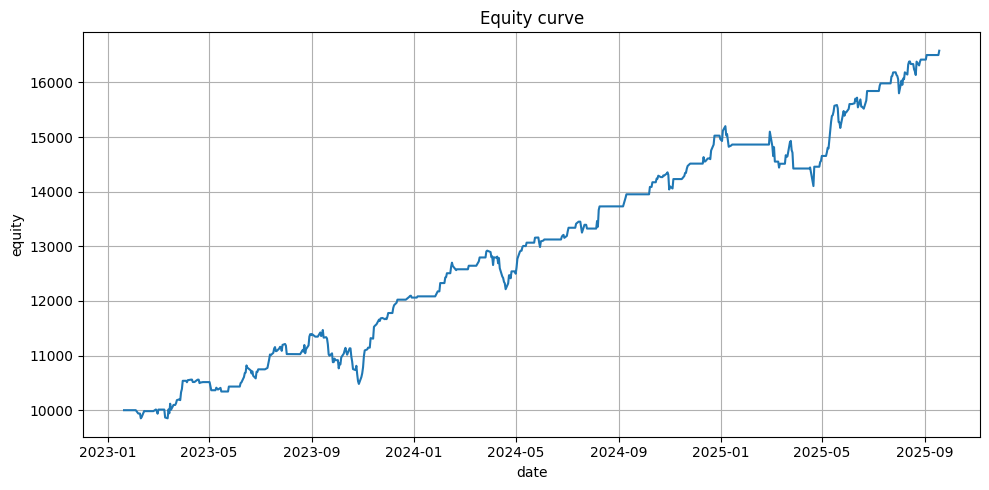

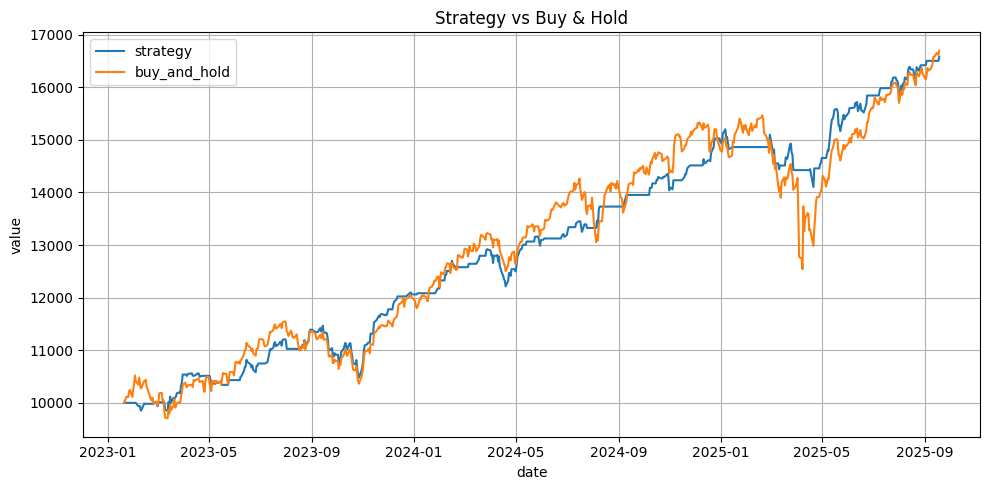

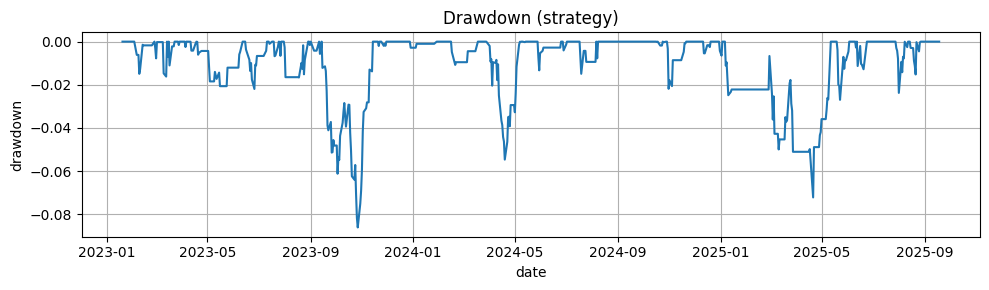


--- Performance summary ---
total_return: 0.6581
cagr: 0.2091
ann_vol: 0.0889
sharpe: 2.1931
max_drawdown: -0.0861
n_periods: 668
n_trades: 128

Buy & Hold comparator:
  total_return: 0.6694
  cagr: 0.2122
  ann_vol: 0.1529
  sharpe: 1.3408
  max_drawdown: -0.1890

--- Basic risk analysis ---
Max drawdown: -8.61%
Annualized volatility: 8.89%
Sharpe (annualized, rf=0): 2.19

Notes:
- Execution uses close prices and "full allocation" sizing (1 or -1 means 100% exposure).
- Adjust fee parameter, position sizing or execution assumptions for a more realistic simulation.

Running backtest for strategy 2


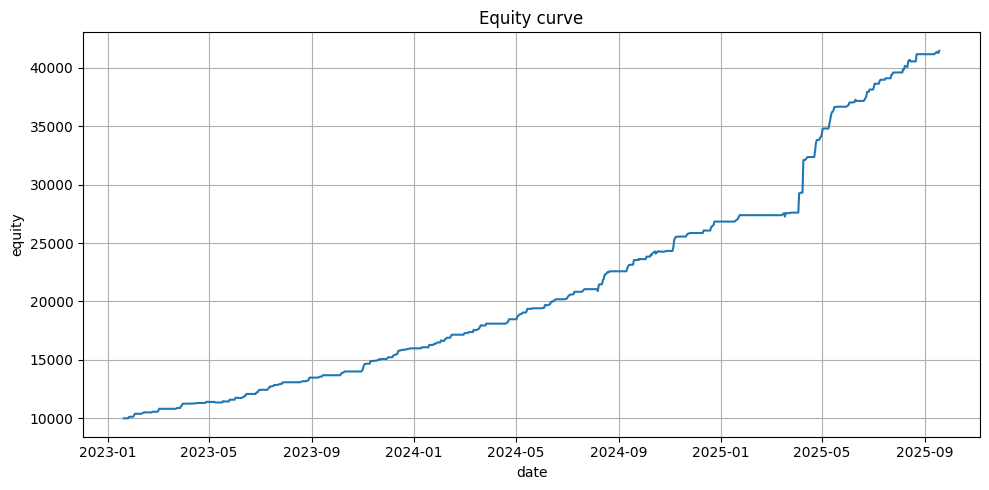

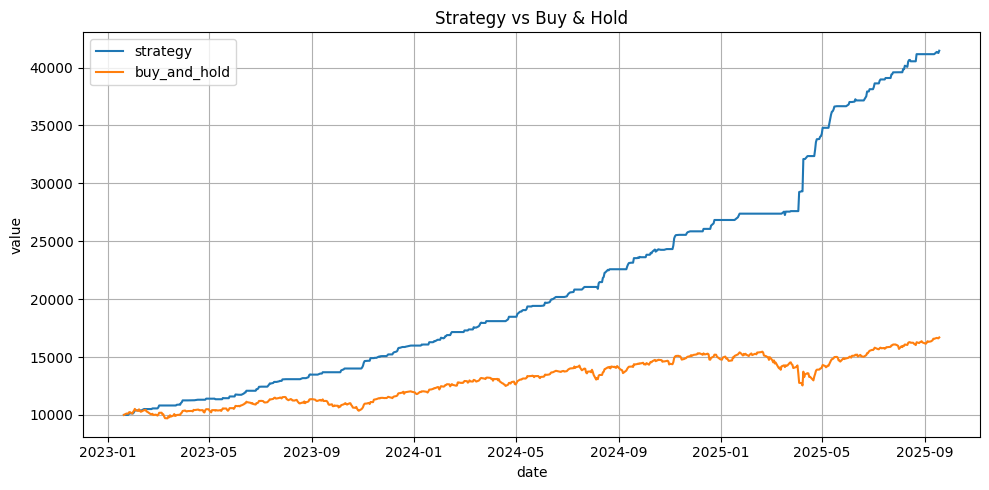

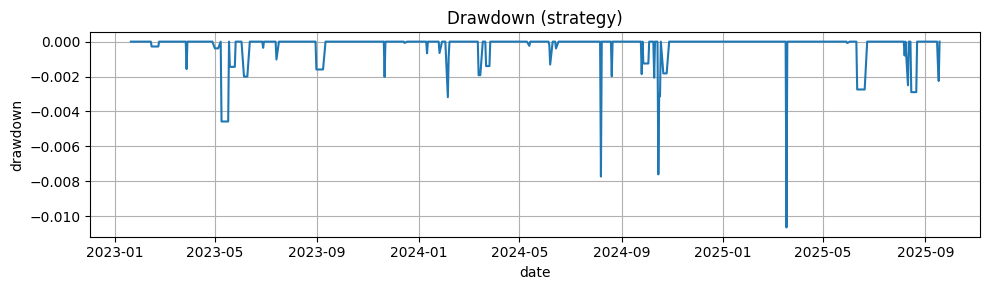


--- Performance summary ---
total_return: 3.1456
cagr: 0.7057
ann_vol: 0.0954
sharpe: 5.6846
max_drawdown: -0.0107
n_periods: 668
n_trades: 238

Buy & Hold comparator:
  total_return: 0.6694
  cagr: 0.2122
  ann_vol: 0.1529
  sharpe: 1.3408
  max_drawdown: -0.1890

--- Basic risk analysis ---
Max drawdown: -1.07%
Annualized volatility: 9.54%
Sharpe (annualized, rf=0): 5.68

Notes:
- Execution uses close prices and "full allocation" sizing (1 or -1 means 100% exposure).
- Adjust fee parameter, position sizing or execution assumptions for a more realistic simulation.

Done. Use the exported functions with your real dataset:
from backtest_strategies import strategy_1, strategy_2, backtest


In [54]:
df = rf.copy()

pos1 = strategy_1(df, x=0.03, tol=0.005)
pos2 = strategy_2(df, x=0.03, tol=0.005, growth_window=1)

print('Running backtest for strategy 1')
metrics1, results1 = backtest(df, pos1, initial_cash=10000.0, fee=0.000)

print('\nRunning backtest for strategy 2')
metrics2, results2 = backtest(df, pos2, initial_cash=10000.0, fee=0.000)

print('\nDone. Use the exported functions with your real dataset:')
print("from backtest_strategies import strategy_1, strategy_2, backtest")